# Computer Vision (911.908)

## <font color='crimson'>The Perceptron</font>

---

## Content

- [Perceptron model](#Perceptron-model)
- [Perceptron learning rule](#Perceptron-learning-rule)
- [Implementation](#Implementation)
    - [Dataset](#Dataset)
    - [Model](#Model)
    - [Preprocessing](#Preprocessing)
    - [Model training](#Model-training)
    - [Model evaluation](#Model-evaluation)
    - [Visualizing the decision boundary](#Visualizing-the-decision-boundary)

---

## Perceptron model

In this part, we discuss the *classic* perceptron model, also known as the **Rosenblatt Perceptron** (Rosenblatt, 1957). If you want to read the original paper, see [here](https://www.ling.upenn.edu/courses/cogs501/Rosenblatt1958.pdf).

**Mathematical model**: Upon receiving an input $\mathbf{x} \in \mathbb{R}^d$, the perceptron computes

$$
\text{output} = \begin{cases}
1 & \text{if}~\sum_{i=1}^{d} w_i x_i > \theta \\
0 & \text{else}
\end{cases}
$$

where $\mathbf{w} = [w_1,\ldots,w_d]^\top$ and $\theta$ (i.e., a scalar) represent the **model parameters**.

Effectively, we compute the inner product (in $\mathbb{R}^d$) between a weight vector $\mathbf{w}$ and the input $\mathbf{x}$, and then apply a *threshold* function on the output. In modern treatments of the subject, its more convenient to first define

$$ \phi_\theta(z) = \begin{cases}
1 & \text{if}~z-\theta > 0\\
0 & \text{if}~z-\theta \leq 0
\end{cases}
$$
 
and then write the perceptron computation as

$$
\text{output} = \phi_\theta(\mathbf{w}^\top \mathbf{x})
$$

For our purposes, it will be even more convenient to write $\mathbf{w}=[w_0,w_1,\ldots,w_d]^\top$ and 
$\mathbf{x} = [1,x_1,\ldots,x_d]^\top$ with $w_0 = -\theta$. That is, we include the **bias** term $-\theta = w_0$ into $\mathbf{w}$. This then allows to define

$$
\phi(z) = \begin{cases}
1 & \text{if}~z > 0 \\
0 & \text{if}~z \leq 0
\end{cases}
$$

and write

<font color='blue'>
$$
\text{output} = \phi(\mathbf{w}^\top \mathbf{x})
$$
</font>

with our newly adjusted weight vector and input vector.

---

## Perceptron learning rule

The perceptron learning rule is quite simple. Given a collection of training points 

$$(\mathbf{x}_1,y_1), \ldots, (\mathbf{x}_N,y_N)$$ 

with $y_i \in \mathcal{Y} = \{0,1\}$, we distinguish between the following **three cases**:

1. if correct: do nothing
2. if incorrect (output $0$, desired $1$): <font color='blue'>add</font> input vector to weight vector $\mathbf{w}$
3. if incorrect (output $1$, desired $0$): <font color='blue'>subtract</font> input vector from weight vector $\mathbf{w}$

**Algorithmically**, we have:

Initialize $\mathbf{w}^{(1)} = \mathbf{0}$ (i.e., all zeros)    
For every training epoch (i.e., one run over all training points):    
&nbsp;&nbsp;&nbsp;&nbsp; $\forall i \in \{1,\ldots,N\}: \hat{y}_i = \phi(\mathbf{w}^\top \mathbf{x}_i)$      
&nbsp;&nbsp;&nbsp;&nbsp; $\forall i \in \{1,\ldots,N\}: \text{err}_i = (y_i - \hat{y}_i)$   
&nbsp;&nbsp;&nbsp;&nbsp; $\forall i \in \{1,\ldots,N\}: \mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} + \text{err}_i \cdot \mathbf{x}_i$    
Terminate if no errors occur, or if we reach a **certain number of runs (epochs)** over the training data.
    
**Note**: if $\hat{y_i} = y_i$, then we do nothing; otherwise, we either add or subtract the input sample $\mathbf{x}_i$ from the current weight vector $\mathbf{w}^{(t)}$.

---

## Implementation

In [12]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dataset

We use some simple aleady prepared **toy data**. From that toy data, we are going to use 70% for training, 30% for testing.

In [23]:
data = np.genfromtxt('../data/perceptron/perceptron_toydata.txt', 
                     delimiter='\t')

print(data[-10:,:])
print(data.shape)

[[ 1.65  0.63  1.  ]
 [ 1.36 -0.22  1.  ]
 [ 2.63  0.4   1.  ]
 [ 0.9   2.05  1.  ]
 [ 1.26  3.54  1.  ]
 [ 0.71  2.27  1.  ]
 [ 1.96  0.83  1.  ]
 [ 2.52  1.83  1.  ]
 [ 2.77  2.82  1.  ]
 [ 4.16  3.34  1.  ]]
(100, 3)


In case you want to execute the notebook within Google collab, use the following data loading code (the previous cell will obviously not work as it references a file on the local harddisk).

In [24]:
# import pandas as pd
# import requests
# import io
    
# # Downloading the csv file from your GitHub account

# url = "https://raw.githubusercontent.com/rkwitt/teaching/master/WS2223/CV/material/data/perceptron/perceptron_toydata.txt" # Make sure the url is the raw version of the file on GitHub
# download = requests.get(url).content
# df = pd.read_csv(io.StringIO(download.decode('utf-8')), delimiter='\t')
# data = df.to_numpy(dtype=np.float32)
# print(data[-10:,:])
# print(data.shape)

In [25]:
X = data[:, 0:2]                  # first two-columns are our x_i vectors
y = data[:, 2].astype(np.int32)   # last column is our target (0 or 1)

print('Class label counts:', np.bincount(y))
print('X.shape:', X.shape)
print('y.shape:', y.shape)

# implement random shuffling by hand, just for demonstration
shuffle_idx = np.arange(y.shape[0])      
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)

X = X[shuffle_idx]
y = y[shuffle_idx]

# split the data into 70% training, 30% testing
X_train, X_test = X[shuffle_idx[:70]], X[shuffle_idx[70:]]
y_train, y_test = y[shuffle_idx[:70]], y[shuffle_idx[70:]]

Class label counts: [50 50]
X.shape: (100, 2)
y.shape: (100,)


### Preprocessing

For numerical stability, we perform some **simple pre-processing** on our data: (1) we subtract the mean and (2) divide by the standard deviation.

In [26]:
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0) # compute mean & std. deviation
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

# let's check if we have mean 0 and std. dev. 1 per column
print("Mean along colum:     ", X_train.mean(axis=0))
print("Std. dev along colum: ", X_train.std(axis=0))

# add a column of all ones to X, such that each row is [x_1, x_2, 1]
X_train = np.c_[ X_train, np.ones(X_train.shape[0])]
X_test  = np.c_[ X_test, np.ones(X_test.shape[0])]

Mean along colum:      [2.06184276e-17 7.93016446e-18]
Std. dev along colum:  [1. 1.]


In [32]:
X_train

array([[ 1.37001499,  0.89400639,  1.        ],
       [-1.47257051, -0.30436276,  1.        ],
       [ 1.78644472,  1.28241061,  1.        ],
       [ 0.75442323,  0.49612888,  1.        ],
       [-0.70760722, -1.02433157,  1.        ],
       [ 0.21125402, -1.03854148,  1.        ],
       [ 0.3832576 , -0.63592734,  1.        ],
       [-1.29604052, -2.21322744,  1.        ],
       [ 0.6503158 ,  1.17346797,  1.        ],
       [ 0.740844  ,  1.72765449,  1.        ],
       [-1.13761617, -1.14274749,  1.        ],
       [-2.35069406, -0.46540841,  1.        ],
       [ 1.07579834,  1.48134937,  1.        ],
       [-0.63518466, -0.65013725,  1.        ],
       [-1.25077642, -2.04744514,  1.        ],
       [-0.48128671, -1.35589615,  1.        ],
       [ 0.44210094,  0.87505984,  1.        ],
       [ 0.62768375,  0.7803271 ,  1.        ],
       [-1.16024822, -1.13801085,  1.        ],
       [-0.73023927,  0.28298022,  1.        ],
       [ 0.47378581,  1.17346797,  1.   

Visually, the **training** data looks like this:

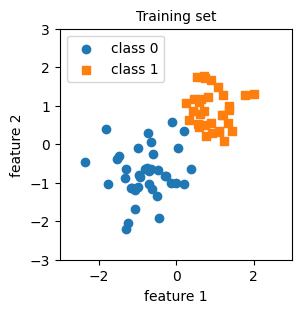

In [33]:
plt.figure(figsize=(3,3))
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')
plt.title('Training set',fontsize=10)
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend()
plt.show()

And the **testing** data looks like this:

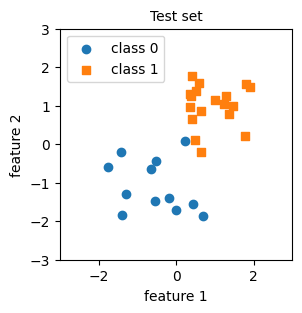

In [29]:
plt.figure(figsize=(3,3))
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')
plt.title('Test set', fontsize=10)
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend()
plt.show()

### Model

Lets implement the Perceptron model and its learning rule. We will implement this as a class called `Perceptron`.

In [30]:
class Perceptron():
    def __init__(self, num_features):
        """Constructor
        
        Args:
            num_features (int): Number of input features 
                                (excluding the additional '1')
        """
        # number of features for an input, i.e., 2 + 1 in our case (because of the added all-'1' column)
        self.num_features = num_features + 1
        # initialize the weights to 0
        self.weights = np.zeros((self.num_features, 1), dtype=np.float32)

        
    def forward(self, x):
        """Computes the perceptron output.
        
        Args:
            x (np.array): Input data; shape = (N, num_features + 1)
            
        Returns:
            y (np.array): Predictions (0/1)
        """
        output = np.dot(x, self.weights) # compute <w,x> = w^T x
        # if output > 0 => assign 1, otherwise assign 0
        predictions = np.where(output > 0., 1, 0)
        return predictions
        
    def compute_errors(self, x, y):
        """Perceptron error computation.
        
        Args:
            x (np.array): Input data; shape = (N, num_features + 1)
            y (np.array): True labels of input featuers (0/1)
            
        Returns:
            e (np.array): errors (in {+/- 1})
        """
        # run data through the perceptron model
        predictions = self.forward(x)
        # compute errors
        errors = y - predictions
        return errors
        
    def train(self, x, y, epochs):
        """Implementation of the perceptron learning rule.
        
        Args: 
            x (np.array): Input features
            y (np.array): Labels of input features (0/1)
            epochs (int): Number of times to run through the data
        """
        # go over the training data epoch times
        for e in range(epochs):
            
            # iterate over all training samples
            for i in range(y.shape[0]):
                
                # compute perceptron errors
                errors = self.compute_errors(
                    x[i].reshape(1, self.num_features), 
                    y[i])
                # make sure we just have a vector
                errors = errors.reshape(-1)
                # update weight
                self.weights += (errors * x[i]).reshape(self.num_features, 1)
                
    def evaluate(self, x, y):
        """Computes accuracy of perceptron model.
        
        Args:
            x (np.array): Input features
            y (np.array): Labels of input features (0/1)
            
        Returns:
            acc (float): Accuracy (in [0,1]) of perceptron model on input data.
        """
        predictions = self.forward(x).reshape(-1)
        accuracy = np.sum(predictions == y) / y.shape[0]
        return accuracy

### Model training

In [35]:
ppn = Perceptron(num_features=2)

ppn.train(X_train, y_train, epochs=100)

print('Model parameters:')
print('Weights:')
print('--------')
print(ppn.weights)
print(ppn.weights.shape)

Model parameters:
Weights:
--------
[[ 1.2734085]
 [ 1.3464228]
 [-1.       ]]
(3, 1)


As mentioned in the discussion of the model, the first two values represent $\mathbf{w}$, the last one represents $\theta$ (i.e., the threshold/bias).

### Model evaluation

In [10]:
train_acc = ppn.evaluate(X_train, y_train)
test_acc = ppn.evaluate(X_test, y_test)

print('Train accuracy: %.3f%%' % (train_acc*100))
print('Test accuracy: %.3f%%' % (test_acc*100))

Train accuracy: 100.000%
Test accuracy: 93.333%


We see that the training data is perfectly **linearly separable**; the testing error (on previously unseen data) is also close to 100\%.

### Visualizing the decision boundary

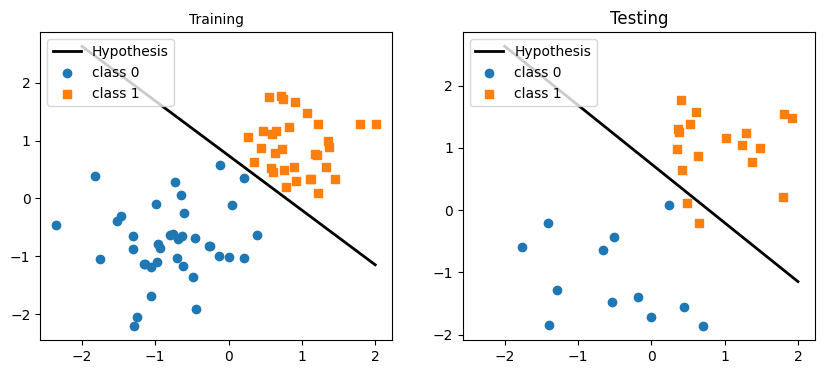

In [34]:
# compute line equation based on weights + bias
w = ppn.weights[0:2,:]
b = ppn.weights[-1,:]

x_min = -2
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] )

x_max = 2
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] )

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(10, 4))

# plot the hypothesis (i.e., the line in 2D)
ax[0].plot([x_min, x_max], 
           [y_min, y_max], 
           label='Hypothesis', lw=2, color='black')
ax[1].plot([x_min, x_max], 
           [y_min, y_max], 
           label='Hypothesis', 
           lw=2, color='black')

# plot the training points of both classes
ax[0].scatter(
    X_train[y_train==0, 0], 
    X_train[y_train==0, 1], 
    label='class 0', 
    marker='o')
ax[0].scatter(
    X_train[y_train==1, 0], 
    X_train[y_train==1, 1], 
    label='class 1', marker='s')

# plot the testing points of both classes
ax[1].scatter(
    X_test[y_test==0, 0], 
    X_test[y_test==0, 1], 
    label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], 
              X_test[y_test==1, 1], 
              label='class 1', 
              marker='s')

ax[0].set_title('Training', fontsize=10)
ax[0].legend(loc='upper left')
ax[1].set_title('Testing')
ax[1].legend(loc='upper left')
plt.show()